In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy
import pandas
import matplotlib.pyplot as plt
import subprocess
from tqdm import tqdm
import lightgbm as lightgbm
import csv
import sklearn
# print(subprocess.check_output("ls").decode("utf-8"))

In [2]:
# Read the data files
# Questions:
# 1. What are the aisles and departments do they matter?
# 2. What is the difference between the training set and the prior orders?
trainingOrderItems = pandas.read_csv("./order_products__train.csv")
priorOrderItems = pandas.read_csv("./order_products__prior.csv")
#aisles = pandas.read_csv("./aisles.csv", )
orders = pandas.read_csv("./orders.csv")
#departments = pandas.read_csv("./departments.csv")
products = pandas.read_csv("./products.csv")

In [3]:
# Product information
productGroup = priorOrderItems.groupby("product_id")
productReorders = productGroup['order_id'].aggregate(numpy.size).to_frame()
productReorders['reordered'] = productGroup['reordered'].aggregate(numpy.mean)
del productGroup

In [4]:
orderGroup = priorOrderItems.groupby("order_id").aggregate(numpy.max)['add_to_cart_order'].to_frame()
priorOrderItems = pandas.merge(priorOrderItems,orderGroup.rename(columns={'add_to_cart_order':'basket_size'}),left_on='order_id', right_index=True)
priorOrderItems.head()

,order_id,product_id,add_to_cart_order,reordered,basket_size
0,2,33120,1,1,9
1,2,28985,2,1,9
2,2,9327,3,0,9
3,2,45918,4,1,9
4,2,30035,5,0,9


In [5]:
# Let's now look at products by user
orderItems = pandas.merge(orders,priorOrderItems, on='order_id')
orderItems['user_product_id'] = 1000000*orderItems['user_id']+orderItems['product_id']
userProducts = orderItems[orderItems['eval_set']=='prior']
userProducts = userProducts[['user_id','order_dow','order_hour_of_day','days_since_prior_order',
                           'product_id','add_to_cart_order', 'user_product_id', 'basket_size', 'order_number', 'order_id']]
userProducts['orders'] = userProducts['user_id']
userAvgProducts = userProducts.groupby('user_product_id').aggregate({'user_id':'mean','order_dow':'mean','order_hour_of_day':'mean',
                                                   'days_since_prior_order':'mean', 'orders':'count',
                                                   'product_id':'mean','add_to_cart_order':'mean', 'basket_size':'mean'})
del orderItems

In [6]:
lastOrderId = userProducts[userProducts.groupby(['user_product_id'])['order_number'].transform(max) == userProducts['order_number']]
lastOrderId = lastOrderId[['user_product_id','order_id']]
lastOrderId.rename(columns={'order_id':'last_order_id'}, inplace=True)
userAvgProducts = pandas.merge(userAvgProducts, lastOrderId, right_on='user_product_id', left_index=True)
userAvgProducts.set_index('user_product_id', inplace=True)
userAvgProducts.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,orders,product_id,add_to_cart_order,basket_size,last_order_id
user_product_id,,,,,,,,,
1000196,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362
1010258,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362
1010326,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534
1012427,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362
1013032,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362


In [7]:
user_distinct_products = userAvgProducts.groupby('user_id').count()['product_id'].to_frame()
user_distinct_products['user_reordered_products'] = userAvgProducts[userAvgProducts['orders']>1].groupby('user_id').count()['product_id']

In [8]:
user_distinct_products.rename(columns={'product_id':'distinct_products'},inplace=True)
user_distinct_products.head()

,distinct_products,user_reordered_products
user_id,,
1,18,10.0
2,102,37.0
3,33,19.0
4,17,1.0
5,23,8.0


In [9]:
userAvgProducts = pandas.merge(user_distinct_products,userAvgProducts,left_index=True,right_on='user_id')
userAvgProducts.head()

,distinct_products,user_reordered_products,user_id,order_dow,order_hour_of_day,days_since_prior_order,orders,product_id,add_to_cart_order,basket_size,last_order_id
user_product_id,,,,,,,,,,,
1000196,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362
1010258,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362
1010326,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534
1012427,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362
1013032,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362


In [10]:
userAvgProducts['user_reorder_rate'] = userAvgProducts['user_reordered_products']/userAvgProducts['distinct_products']
userAvgProducts.head()

,distinct_products,user_reordered_products,user_id,order_dow,order_hour_of_day,days_since_prior_order,orders,product_id,add_to_cart_order,basket_size,last_order_id,user_reorder_rate
user_product_id,,,,,,,,,,,,
1000196,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556
1010258,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362,0.555556
1010326,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534,0.555556
1012427,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362,0.555556
1013032,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362,0.555556


In [11]:
# Compile the features
features = userAvgProducts
features.columns = ['user_distinct_products','user_reordered_products','user_id','user_product_dow','user_product_hod','user_product_dsp','user_product_orders','product_id','user_product_addCart', 'user_avg_basket_size', 'user_product_last_order_id','user_reorder_rate']

In [12]:
userOrders = orders[orders['eval_set']=='prior'].groupby('user_id').aggregate(numpy.max)
userOrders.head()

,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,,,
1,3367565,prior,10,4,16,30.0
2,3268552,prior,14,5,15,30.0
3,3225766,prior,12,3,19,21.0
4,3343014,prior,5,6,15,21.0
5,2717275,prior,4,3,18,19.0


In [13]:
features.head()

,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate
user_product_id,,,,,,,,,,,,
1000196,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556
1010258,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362,0.555556
1010326,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534,0.555556
1012427,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362,0.555556
1013032,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362,0.555556


In [14]:
userOrders=userOrders[['order_number']]
features = pandas.merge(userOrders,features, right_on='user_id', left_index=True)
features.head()

,order_number,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate
user_product_id,,,,,,,,,,,,,
1000196,10,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556
1010258,10,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362,0.555556
1010326,10,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534,0.555556
1012427,10,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362,0.555556
1013032,10,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362,0.555556


In [15]:
features['order_number'] = features['user_product_orders']/features['order_number']
features.head()

,order_number,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate
user_product_id,,,,,,,,,,,,,
1000196,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556
1010258,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362,0.555556
1010326,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534,0.555556
1012427,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362,0.555556
1013032,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362,0.555556


In [16]:
features.rename(columns={'order_number': 'user_product_reorder_rate'}, inplace=True)
features.head()

,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate
user_product_id,,,,,,,,,,,,,
1000196,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556
1010258,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,6.000000,2550362,0.555556
1010326,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,8.000000,431534,0.555556
1012427,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,5.900000,2550362,0.555556
1013032,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,6.666667,2550362,0.555556


In [17]:
features=pandas.merge(features,productReorders, left_on='product_id',right_index=True)
features.rename(columns={'order_id':'product_total_orders','reordered':'product_reorder_rate'},inplace=True)
features['product_reorders'] = features['product_reorder_rate'] * features['product_total_orders']
features.head()

,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate,product_total_orders,product_reorder_rate,product_reorders
user_product_id,,,,,,,,,,,,,,,,
1000196,1.000000,18,10.0,1,2.5,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556,35791,0.77648,27791.0
15000196,0.227273,13,9.0,15,1.4,11.000000,8.600000,5,196,2.200000,2.800000,487368,0.692308,35791,0.77648,27791.0
19000196,0.333333,133,39.0,19,5.0,14.333333,6.666667,3,196,6.333333,31.333333,532817,0.293233,35791,0.77648,27791.0
21000196,0.030303,102,30.0,21,3.0,10.000000,6.000000,1,196,2.000000,7.000000,1573906,0.294118,35791,0.77648,27791.0
31000196,0.100000,190,66.0,31,3.0,9.500000,7.500000,2,196,15.500000,27.500000,2231262,0.347368,35791,0.77648,27791.0


In [18]:
features = pandas.merge(features, products, on='product_id')
features.drop('product_name',axis=1,inplace=True)
features.head()

,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,user_avg_basket_size,user_product_last_order_id,user_reorder_rate,product_total_orders,product_reorder_rate,product_reorders,aisle_id,department_id
0,1.000000,18,10.0,1,2.5,10.300000,19.555556,10,196,1.400000,5.900000,2550362,0.555556,35791,0.77648,27791.0,77,7
1,0.227273,13,9.0,15,1.4,11.000000,8.600000,5,196,2.200000,2.800000,487368,0.692308,35791,0.77648,27791.0,77,7
2,0.333333,133,39.0,19,5.0,14.333333,6.666667,3,196,6.333333,31.333333,532817,0.293233,35791,0.77648,27791.0,77,7
3,0.030303,102,30.0,21,3.0,10.000000,6.000000,1,196,2.000000,7.000000,1573906,0.294118,35791,0.77648,27791.0,77,7
4,0.100000,190,66.0,31,3.0,9.500000,7.500000,2,196,15.500000,27.500000,2231262,0.347368,35791,0.77648,27791.0,77,7


In [19]:
user_order_group = orders[orders['eval_set']=='prior'].groupby('user_id').aggregate({'order_id':'count', 'days_since_prior_order':'mean'})
user_order_group.columns = [['user_orders','user_order_dsp']]
features = pandas.merge(features,user_order_group,left_on='user_id', right_index=True)
features['user_total_products'] = features['user_avg_basket_size']*features['user_orders']
features.head()

,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_product_addCart,...,user_product_last_order_id,user_reorder_rate,product_total_orders,product_reorder_rate,product_reorders,aisle_id,department_id,user_orders,user_order_dsp,user_total_products
0,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,1.400000,...,2550362,0.555556,35791,0.776480,27791.0,77,7,10,19.555556,59.000000
8000,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,3.333333,...,2550362,0.555556,1946,0.713772,1389.0,117,19,10,19.555556,60.000000
8557,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,5.000000,...,431534,0.555556,5526,0.652009,3603.0,24,4,10,19.555556,80.000000
10480,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,3.300000,...,2550362,0.555556,6476,0.740735,4797.0,23,19,10,19.555556,59.000000
12159,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.333333,...,2550362,0.555556,3751,0.657158,2465.0,121,14,10,19.555556,66.666667


In [20]:
# Ready the inputs into lightGBM
train_orders = orders[orders['eval_set']=='train']
test_orders = orders[orders['eval_set']=='test']

test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [21]:
train_features = pandas.merge(train_orders, features, on='user_id')
test_features = pandas.merge(test_orders, features, on='user_id')


In [22]:
test_features.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,...,user_product_last_order_id,user_reorder_rate,product_total_orders,product_reorder_rate,product_reorders,aisle_id,department_id,user_orders,user_order_dsp,user_total_products
0,2774568,3,test,13,5,15,11.0,0.250000,33,19.0,...,3160850,0.575758,142951,0.698155,99802.0,24,4,12,12.090909,96.000000
1,2774568,3,test,13,5,15,11.0,0.750000,33,19.0,...,1402502,0.575758,176815,0.758103,134044.0,24,4,12,12.090909,86.666667
2,2774568,3,test,13,5,15,11.0,0.083333,33,19.0,...,444309,0.575758,6371,0.400251,2550.0,117,19,12,12.090909,108.000000
3,2774568,3,test,13,5,15,11.0,0.083333,33,19.0,...,676467,0.575758,463,0.440605,204.0,94,7,12,12.090909,72.000000
4,2774568,3,test,13,5,15,11.0,0.250000,33,19.0,...,1839752,0.575758,2424,0.492162,1193.0,88,13,12,12.090909,88.000000


In [23]:
del train_orders
del test_orders
del features

In [24]:
train_features['diff_order_hod'] = abs(train_features['user_product_hod']-train_features['order_hour_of_day']).map(lambda x: min(x, 24-x))
train_features['ratio_dsp'] = train_features['user_product_dsp']/train_features['days_since_prior_order']
train_features['diff_dow'] = abs(train_features['user_product_dow']-train_features['order_dow']).map(lambda x: min (x, 7-x))
train_features['order_dow_30'] = train_features['order_dow'].map(lambda x: x==30)

# Last Order features
train_features['user_product_orders_since_last'] = train_features['order_number'] - train_features['user_product_last_order_id'].map(orders.order_number)
train_features['user_product_hour_vs_last'] = abs(train_features['order_hour_of_day'] - train_features['user_product_last_order_id'].map(orders.order_hour_of_day) \
                                                 ).map(lambda x: min(x, 24-x))
train_features['user_product_dow_vs_last'] = abs(train_features['user_product_last_order_id'].map(orders.order_dow) \
                                                 -train_features['order_dow']).map(lambda x: min (x, 7-x))
train_features['user_product_same_dow'] = (train_features['user_product_last_order_id'].map(orders.order_dow) \
                                                 -train_features['order_dow']).map(lambda x: x==0)
train_features['user_product_same_hod'] = (train_features['order_hour_of_day'] - train_features['user_product_last_order_id'].map(orders.order_hour_of_day) \
                                                 ).map(lambda x: x==0)

# Last Order features
test_features['diff_order_hod'] = abs(test_features['user_product_hod']-test_features['order_hour_of_day']).map(lambda x: min(x, 24-x))
test_features['ratio_dsp'] = test_features['user_product_dsp']/test_features['days_since_prior_order']
test_features['diff_dow'] = abs(test_features['user_product_dow']-test_features['order_dow']).map(lambda x: min (x, 7-x))
test_features['order_dow_30'] = test_features['order_dow'].map(lambda x: x==30)

test_features['user_product_orders_since_last'] = test_features['order_number'] - test_features['user_product_last_order_id'].map(orders.order_number)
test_features['user_product_hour_vs_last'] = abs(test_features['order_hour_of_day'] - test_features['user_product_last_order_id'].map(orders.order_hour_of_day) \
                                                 ).map(lambda x: min(x, 24-x))
test_features['user_product_dow_vs_last'] = abs(test_features['user_product_last_order_id'].map(orders.order_dow) \
                                                 -test_features['order_dow']).map(lambda x: min (x, 7-x))
test_features['user_product_same_dow'] = (test_features['user_product_last_order_id'].map(orders.order_dow) \
                                                 -test_features['order_dow']).map(lambda x: x==0)
test_features['user_product_same_hod'] = (test_features['order_hour_of_day'] - test_features['user_product_last_order_id'].map(orders.order_hour_of_day) \
                                                 ).map(lambda x: x==0)

test_features.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,...,user_total_products,diff_order_hod,ratio_dsp,diff_dow,order_dow_30,user_product_orders_since_last,user_product_hour_vs_last,user_product_dow_vs_last,user_product_same_dow,user_product_same_hod
0,2774568,3,test,13,5,15,11.0,0.250000,33,19.0,...,96.000000,0.000000,0.636364,2.333333,False,8.0,1.0,2.0,False,False
1,2774568,3,test,13,5,15,11.0,0.750000,33,19.0,...,86.666667,1.111111,1.102273,2.888889,False,-13.0,0.0,0.0,True,True
2,2774568,3,test,13,5,15,11.0,0.083333,33,19.0,...,108.000000,4.000000,0.818182,2.000000,False,0.0,4.0,3.0,False,False
3,2774568,3,test,13,5,15,11.0,0.083333,33,19.0,...,72.000000,1.000000,1.545455,2.000000,False,7.0,2.0,1.0,False,False
4,2774568,3,test,13,5,15,11.0,0.250000,33,19.0,...,88.000000,1.333333,1.030303,2.666667,False,-13.0,9.0,2.0,False,False


In [25]:
train_features.sort_values(['order_id','product_id'], inplace=True)
test_features.sort_values(['order_id','product_id'], inplace=True)
test_features.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,...,user_total_products,diff_order_hod,ratio_dsp,diff_dow,order_dow_30,user_product_orders_since_last,user_product_hour_vs_last,user_product_dow_vs_last,user_product_same_dow,user_product_same_hod
858095,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,36.000000,6.0,30.0,1.000000,False,-4.0,3.0,3.0,False,False
858092,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,36.000000,1.0,6.0,0.000000,False,-36.0,2.0,1.0,False,False
858088,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,20.000000,2.0,NaN,2.000000,False,-5.0,2.0,3.0,False,False
858094,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,20.000000,2.0,NaN,2.000000,False,-5.0,2.0,3.0,False,False
858097,17,36855,test,5,6,15,1.0,0.75,21,5.0,...,29.333333,3.0,14.0,2.333333,False,-10.0,3.0,1.0,False,False


In [26]:
train_features.drop(['eval_set','order_number', 'order_number'], axis=1, inplace=True)
test_features.drop(['eval_set','order_number', 'order_number'], axis=1, inplace=True)
train_features.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_product_dow,user_product_hod,...,user_total_products,diff_order_hod,ratio_dsp,diff_dow,order_dow_30,user_product_orders_since_last,user_product_hour_vs_last,user_product_dow_vs_last,user_product_same_dow,user_product_same_hod
4629306,1,112108,4,10,9.0,0.333333,12,8.0,1.000000,10.0,...,24.0,0.0,0.777778,3.000000,False,-1,1,2,False,False
4629308,1,112108,4,10,9.0,0.666667,12,8.0,1.500000,15.5,...,19.5,5.5,1.222222,2.500000,False,3,0,1,False,True
4629307,1,112108,4,10,9.0,0.666667,12,8.0,1.000000,12.0,...,24.0,2.0,0.777778,3.000000,False,-1,1,2,False,False
4629304,1,112108,4,10,9.0,1.000000,12,8.0,1.333333,15.0,...,21.0,5.0,1.222222,2.666667,False,3,0,1,False,True
4629302,1,112108,4,10,9.0,0.666667,12,8.0,1.000000,12.0,...,24.0,2.0,0.777778,3.000000,False,-1,1,2,False,False


In [27]:
test_features.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_product_dow,user_product_hod,...,user_total_products,diff_order_hod,ratio_dsp,diff_dow,order_dow_30,user_product_orders_since_last,user_product_hour_vs_last,user_product_dow_vs_last,user_product_same_dow,user_product_same_hod
858095,17,36855,6,15,1.0,0.25,21,5.0,0.000000,9.0,...,36.000000,6.0,30.0,1.000000,False,-4.0,3.0,3.0,False,False
858092,17,36855,6,15,1.0,0.25,21,5.0,6.000000,14.0,...,36.000000,1.0,6.0,0.000000,False,-36.0,2.0,1.0,False,False
858088,17,36855,6,15,1.0,0.25,21,5.0,1.000000,13.0,...,20.000000,2.0,NaN,2.000000,False,-5.0,2.0,3.0,False,False
858094,17,36855,6,15,1.0,0.25,21,5.0,1.000000,13.0,...,20.000000,2.0,NaN,2.000000,False,-5.0,2.0,3.0,False,False
858097,17,36855,6,15,1.0,0.75,21,5.0,3.666667,12.0,...,29.333333,3.0,14.0,2.333333,False,-10.0,3.0,1.0,False,False


In [28]:
train_orders = orders[orders['eval_set']=='train']
trainProducts = pandas.merge(train_orders,trainingOrderItems, on='order_id')
trainProducts.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1


In [29]:
trainProducts = trainProducts.groupby('user_id')['product_id'].apply(set)
trainProducts.head()

user_id
1    {196, 26405, 27845, 46149, 13032, 39657, 26088...
2    {24838, 11913, 45066, 31883, 48523, 38547, 248...
5    {40706, 21413, 20843, 48204, 21616, 19057, 201...
7    {17638, 29894, 47272, 45066, 13198, 37999, 408...
8    {27104, 15937, 5539, 41540, 31717, 48230, 2224...
Name: product_id, dtype: object

In [30]:
trainLabels = []
for row in tqdm(train_features.itertuples()):
    trainLabels += [row.product_id in trainProducts[row.user_id]]
print(len(trainLabels))
print(train_features.shape)

8474661it [02:09, 65584.69it/s]

8474661
(8474661, 34)


In [31]:
num_feature_list=['diff_dow','ratio_dsp','diff_order_hod', 'user_avg_basket_size', 'user_product_hour_vs_last',
                  'days_since_prior_order','user_product_reorder_rate','user_product_dow','user_reordered_products',
                  'user_product_hod','user_product_dsp','user_product_orders','user_product_addCart',
                  'product_reorder_rate','product_total_orders', 'user_reorder_rate', 'user_distinct_products',
                  'user_product_orders_since_last']

#num_feature_list=['diff_dow','ratio_dsp','diff_order_hod', 'user_avg_basket_size',
#                  'days_since_prior_order','user_product_reorder_rate','user_product_dow',
#                  'user_product_hod','user_product_dsp','user_product_addCart',
#                  'product_reorder_rate', 'user_reorder_rate', 
#                  'user_product_orders_since_last']


#cat_feature_list=['department_id','aisle_id','order_dow','order_hour_of_day']
cat_feature_list = ['aisle_id', 'department_id', 'order_dow', 'order_hour_of_day', 'order_dow_30',
                    'user_product_same_dow', 'user_product_same_hod']
feature_list = num_feature_list+cat_feature_list
test_features[num_feature_list][200000:200020]

,diff_dow,ratio_dsp,diff_order_hod,user_avg_basket_size,user_product_hour_vs_last,days_since_prior_order,user_product_reorder_rate,user_product_dow,user_reordered_products,user_product_hod,user_product_dsp,user_product_orders,user_product_addCart,product_reorder_rate,product_total_orders,user_reorder_rate,user_distinct_products,user_product_orders_since_last
4587600,0.0,0.633333,1.000000,20.0,0.0,30.0,0.250000,1.0,16.0,19.000000,19.000000,1,14.000000,0.711706,4707,0.533333,30,1.0
729917,2.0,0.875000,3.000000,11.0,0.0,8.0,0.142857,4.0,18.0,16.000000,7.000000,1,10.000000,0.468000,11297,0.276923,65,7.0
729939,0.0,3.750000,1.000000,23.0,8.0,8.0,0.142857,6.0,18.0,18.000000,30.000000,1,13.000000,0.214286,14,0.276923,65,0.0
729933,1.0,0.750000,6.000000,16.0,7.0,8.0,0.142857,5.0,18.0,1.000000,6.000000,1,12.000000,0.482746,5448,0.276923,65,-16.0
729938,0.0,3.750000,1.000000,23.0,8.0,8.0,0.142857,6.0,18.0,18.000000,30.000000,1,23.000000,0.000000,22,0.276923,65,0.0
729916,1.0,0.750000,6.000000,16.0,7.0,8.0,0.142857,5.0,18.0,1.000000,6.000000,1,16.000000,0.154561,4626,0.276923,65,-16.0
729898,1.0,0.750000,6.000000,16.0,7.0,8.0,0.142857,5.0,18.0,1.000000,6.000000,1,7.000000,0.543536,4927,0.276923,65,-16.0
729923,1.0,3.083333,1.666667,21.0,8.0,8.0,0.428571,5.0,18.0,17.333333,24.666667,3,7.333333,0.621827,6066,0.276923,65,0.0
729936,1.0,0.750000,6.000000,16.0,7.0,8.0,0.142857,5.0,18.0,1.000000,6.000000,1,4.000000,0.181287,171,0.276923,65,-16.0
729922,1.0,0.750000,6.000000,16.0,7.0,8.0,0.142857,5.0,18.0,1.000000,6.000000,1,3.000000,0.549889,12648,0.276923,65,-16.0


In [32]:
#train_dataset = lightgbm.Dataset(train_features[feature_list].iloc[:4000000],label=numpy.array(trainLabels[:4000000]),
#                                 categorical_feature=cat_feature_list)
train_dataset = lightgbm.Dataset(train_features[feature_list],label=numpy.array(trainLabels),
                                 categorical_feature=cat_feature_list)

In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'AUC'},
    'num_leaves': 100,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'lambda_l2' : 1,
    'lambda_l1' : .00002
}
rounds = 300

In [34]:
bst = lightgbm.train(params, train_dataset, rounds, callbacks=[lightgbm.print_evaluation()])

In [35]:
def f1(y, t):
    t = t.get_label()
    y = [1 if y_cont > 0.2 else 0 for y_cont in y]
    return "f1", sklearn.metrics.f1_score(t, y), True

cv = lightgbm.cv(params, train_dataset, rounds, feval=f1, callbacks=[lightgbm.print_evaluation()])

[1]	cv_agg's auc: 0.790693 + 0.000488943	cv_agg's f1: 0.178175 + 0.000353651
[2]	cv_agg's auc: 0.793996 + 0.000323257	cv_agg's f1: 0.178175 + 0.000353651
[3]	cv_agg's auc: 0.794729 + 0.00033627	cv_agg's f1: 0.178175 + 0.000353651
[4]	cv_agg's auc: 0.795428 + 0.000389248	cv_agg's f1: 0.178175 + 0.000353651
[5]	cv_agg's auc: 0.795778 + 0.000440962	cv_agg's f1: 0.178175 + 0.000353651
[6]	cv_agg's auc: 0.796115 + 0.00038801	cv_agg's f1: 0.178175 + 0.000353651
[7]	cv_agg's auc: 0.796294 + 0.000464601	cv_agg's f1: 0.178175 + 0.000353651
[8]	cv_agg's auc: 0.796464 + 0.00046701	cv_agg's f1: 0.178175 + 0.000353651


KeyboardInterrupt: 

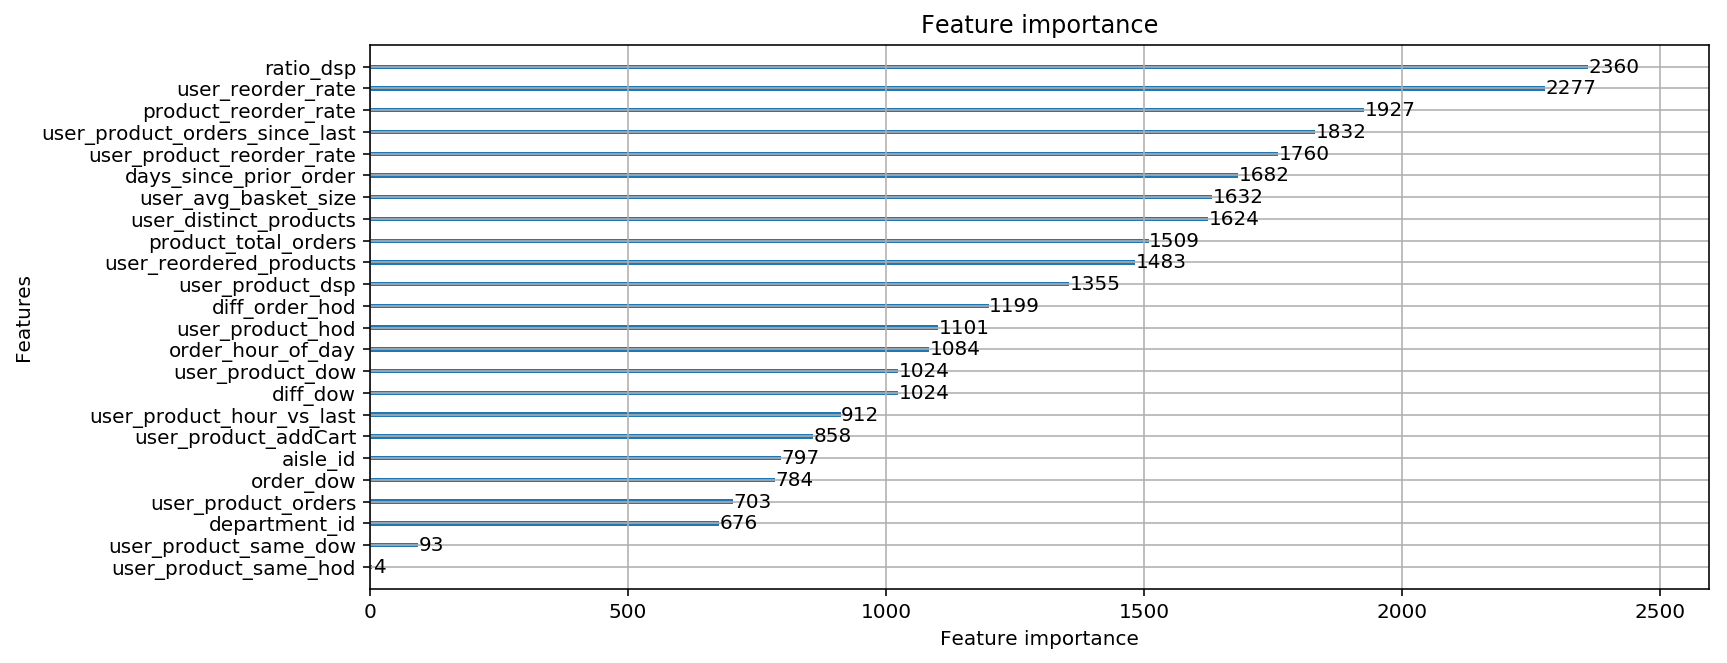

In [36]:
lightgbm.plot_importance(bst, figsize=(12,5))

In [ ]:
# Let's test on the train set for kicks
preds = bst.predict(train_features[feature_list][4000000:])

In [ ]:
print(["{0:0.5f}".format(i) for i in preds[:5]])
print(len(preds))

In [ ]:
truePositive = 0
falsePositive = 0
falseNegative=0
trueNegative=0

def f_score(truePositive, falseNegative, falsePositive, beta=1):
    return ((1+beta**2)*truePositive)/(((1+beta**2)*truePositive)+beta**2*falseNegative+falsePositive)

for i in range(len(preds[4000000:])):
    if preds[[4000000+i] >.2:
        if trainLabels[i] ==1:
            truePositive +=1
        else:
            falsePositive+=1
    else:
        if trainLabels[i] ==1:
            falseNegative+=1
        else:
            trueNegative+=1

print (truePositive, trueNegative, falsePositive, falseNegative)
print (f_score(truePositive, falseNegative, falsePositive))

In [37]:
test_preds = bst.predict(test_features[feature_list])

In [38]:
past_order_id = -1
reorderedProducts = []
output = []
i =0 
for row in tqdm(test_features.itertuples()):
    if (row.order_id!=past_order_id):
        if (past_order_id==-1):
            pass
        else:
            if (reorderedProducts == []):
                reorderedProducts.append('None')
            output.append([past_order_id," ".join(reorderedProducts)])
            reorderedProducts = []
        past_order_id = row.order_id
    if (test_preds[i]>.22):
            reorderedProducts.append(str(row.product_id))
    i+=1
output.append([past_order_id," ".join(reorderedProducts)])

4833292it [00:19, 252898.01it/s]


In [39]:
output[5]

[313, '12779 13198 21903 25890 45007 46906']

In [40]:
with open('predictionLogLoss.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['order_id','products'])
    for row in output:
        wr.writerow(row)

In [41]:
predictions = []
with open('./predictionLogLoss.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        predictions.append(row)
sub = []
with open('./sub_39.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        sub.append(row)
diff = 0
sub.sort(key=lambda x: x[0])
predictions.sort(key=lambda x: x[0])
for i in range(len(sub)):
    subRow = set(sub[i][1].split(" "))
    predRow = set(predictions[i][1].split(" "))
    diffSet = subRow.symmetric_difference(predRow)
    diff += len(diffSet)
print (diff, "resubmit when <200000")

311120 resubmit when <200000
